# loading dragonn's tutorial utilities.

In [1]:
%load_ext autoreload
%autoreload 2
from dragonn.tutorial_utils import (
    get_available_simulations, interpret_SequenceDNN_filters, print_available_simulations,
    print_simulation_info, get_simulation_data,
    inspect_SequenceDNN, get_SequenceDNN,
    train_SequenceDNN, SequenceDNN_learning_curve, test_SequenceDNN,
)
%matplotlib inline

# 1) Simulate regulatory DNA sequence for the classification task

In [2]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


In [3]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: list
        List of embedding objects.
    


In [1]:
# In this tutorial, we will simulate heterodimer motif grammar detection task. Specifically, we will simulate a "positive" class of sequences with a SIX5_known5, ZNF143_known2 grammar with relatively fixed spacing between the motifs and a negative class of sequences containing both motifs positioned independently:
# The following is for fixing the simulation parameters

In [34]:
heterodimer_grammar_simulation_parameters = {
    "seq_length": 500,
    "GC_fraction": 0.4,
    "num_pos": 10000,
    "num_neg": 10000,
    "motif1": "SIX5_known5",
    "motif2": "ZNF143_known2",
    "min_spacing": 2,
    "max_spacing": 10}

In [35]:
simulation_data = get_simulation_data("simulate_heterodimer_grammar", heterodimer_grammar_simulation_parameters)

In [6]:
# Training, validation and Testing data

In [7]:
X_train = simulation_data.X_train
X_valid = simulation_data.X_valid
X_test = simulation_data.X_test

In [8]:
# Training, validation and Testing labels

In [9]:
y_train = simulation_data.y_train
y_valid = simulation_data.y_valid
y_test = simulation_data.y_test

In [10]:
# Statistics about the generated data

In [11]:
print ('train data: number of instances - %d, number of features, length of the sequence', X_train[:,0,:,:].shape)
print ('validate data: number of instances, number of features, length of the sequence', X_valid[:,0,:,:].shape)
print ('test data: number of instances, number of features, length of the sequence', X_test[:,0,:,:].shape)

('train data: number of instances - %d, number of features, length of the sequence', (12800, 4, 500))
('validate data: number of instances, number of features, length of the sequence', (3200, 4, 500))
('test data: number of instances, number of features, length of the sequence', (4000, 4, 500))


In [12]:
# how a single sequence look like

In [13]:
print (X_train[0,0,:,:20])

[[0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1]]


In [14]:
def get_sequence_plot(sequence):
    import numpy as np
    import matplotlib.pyplot as plt
    tempList = sequence
    indexList = []
    for i in range(tempList.shape[1]):
        Index = tempList[:,i].tolist().index(1)
        if Index == 0:
            indexList.append('A')
        elif Index == 1:
            indexList.append('C')
        elif Index == 2:
            indexList.append('G')
        elif Index == 3:
            indexList.append('T')
        else:
            pass

    import matplotlib.pyplot as plt
    x = np.arange(tempList.shape[1])
    labels= np.array(indexList)
    y=np.ones(tempList.shape[1])
    plt.yticks(y, [])
    plt.xticks(x, labels)
    plt.xlabel('DNA sequence')
    mask1 = (labels == 'A')
    mask2 = (labels == 'C')
    mask3 = (labels == 'G')
    mask4 = (labels == 'T')
    plt.bar(x[mask1], y[mask1], color = 'green')
    plt.bar(x[mask2], y[mask2], color = 'blue')
    plt.bar(x[mask3], y[mask3], color = 'yellow')
    plt.bar(x[mask4], y[mask4], color = 'red')
    plt.show()

In [15]:
# plot and see the sequence

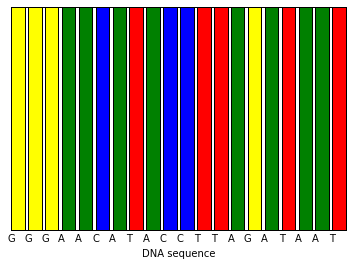

In [16]:
get_sequence_plot(X_train[0,0,:,:20])

In [17]:
# train labels for first 10 instances

In [18]:
simulation_data.y_train[0:10]

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

# Representation of motifs (patterns)

In [2]:
# position-specific scoring matrix (PSSM)

In [20]:
t_sequences = ['GAGGTAAAC','TCCGTAAGT','CAGGTTGGA','ACAGTCAGT','TAGGTCATT','TAGGTACTG','ATGGTAACT','CAGGTATAC','TGTGTGAGT','AAGGTAAGT']

In [23]:
import numpy as np
def get_position_frequency_matrix(t_sequences):
    t_matrix = []
    for t_sequence in t_sequences:
        t_matrix.append([char for char in t_sequence])
    t_matrix = np.matrix(t_matrix)
    p_matrix = []
    for i in range(0, t_matrix.shape[1]):
        temp = []
        a = t_matrix[:,i]
        a = [thing[0] for thing in a.tolist()]
        temp.append(a.count('A'))
        temp.append(a.count('C'))
        temp.append(a.count('G'))
        temp.append(a.count('T'))
        p_matrix.append(temp)
    p_matrix = np.matrix(p_matrix)
    p_matrix = p_matrix.transpose()
    return p_matrix

def get_position_probability_matrix(p_matrix):
    p_matrix = (p_matrix/float(p_matrix.shape[1]))
    p_matrix = np.around(p_matrix, decimals=1)
    return p_matrix

def get_position_weight_matrix(p_matrix):
    p_matrix = p_matrix/float(1.0/p_matrix.shape[0])
    p_matrix = np.log(p_matrix)
    p_matrix = np.around(p_matrix, decimals=2)
    return p_matrix

In [3]:
# calculating position frequency matrix

In [24]:
pfm = get_position_frequency_matrix(t_sequences)
print pfm

[[ 3  6  1  0  0  6  7  2  1]
 [ 2  2  1  0  0  2  1  1  2]
 [ 1  1  7 10  0  1  1  5  1]
 [ 4  1  1  0 10  1  1  2  6]]


In [ ]:
# calculating position frequency matrix

In [25]:
ppm = get_position_probability_matrix(pfm)
print ppm

[[ 0.3  0.7  0.1  0.   0.   0.7  0.8  0.2  0.1]
 [ 0.2  0.2  0.1  0.   0.   0.2  0.1  0.1  0.2]
 [ 0.1  0.1  0.8  1.1  0.   0.1  0.1  0.6  0.1]
 [ 0.4  0.1  0.1  0.   1.1  0.1  0.1  0.2  0.7]]


In [4]:
# calculating position weight matrix and thresholding to get PSSM

In [26]:
pwm = get_position_weight_matrix(ppm)
pwm[pwm<0] = 0
print pwm

[[ 0.18  1.03  0.    0.    0.    1.03  1.16  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.16  1.48  0.    0.    0.    0.88  0.  ]
 [ 0.47  0.    0.    0.    1.48  0.    0.    0.    1.03]]


/home/barathiganeshhb/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


In [5]:
# plotting to visulize the motifs

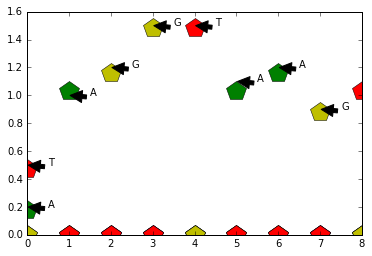

In [27]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(pwm.shape[1])

# green - A, blue - C, yellow - G and green - T
plt.plot(t, pwm[0,:], 'gp', t, pwm[1,:], 'bp', t, pwm[2,:], 'yp', pwm[3,:], 'rp', markersize=20)
plt.annotate('A', xy=(0, 0.2), xytext=(0.5, 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('T', xy=(0, 0.5), xytext=(0.5, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('A', xy=(1, 1.0), xytext=(1.5, 1.0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('G', xy=(2, 1.2), xytext=(2.5, 1.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('G', xy=(3, 1.5), xytext=(3.5, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('T', xy=(4, 1.5), xytext=(4.5, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('A', xy=(5, 1.1), xytext=(5.5, 1.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('A', xy=(6, 1.2), xytext=(6.5, 1.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('G', xy=(7, 0.9), xytext=(7.5, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

# DragoNN Models

In [28]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int, optional
    length of input sequence.
keras_model : instance of keras.models.Sequential, optional
    seq_length or keras_model must be specified.
num_tasks : int, optional
    number of tasks. Default: 1.
num_filters : list[int] | tuple[int]
    number of convolutional filters in each layer. Default: (15,).
conv_width : list[int] | tuple[int]
    width of each layer's convolutional filters. Default: (15,).
pool_width : int
    width of max pooling after the last layer. Default: 35.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
verbose: int
    Verbosity level during training. Valida values: 0, 1, 2.

Returns
-------
Compiled DNN model.

Available methods:

deeplift
get_sequence_filters
in_silico_mutagenesis
plot_architecture
plot_deeplift
plot_in_silico_mutagenesis
predict
save
score
test
train


In [6]:
# parameters for the one filter Convolutional Neural Network

In [36]:
one_filter_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [1],
    'conv_width': [45],
    'pool_width': 45}

# One-filter DragoNN model 

In [37]:
one_filter_dragonn = get_SequenceDNN(one_filter_dragonn_parameters)

In [38]:
train_SequenceDNN(one_filter_dragonn, simulation_data)

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6941	Balanced Accuracy: 50.67%	 auROC: 0.508	 auPRC: 0.503
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6924	Balanced Accuracy: 51.32%	 auROC: 0.516	 auPRC: 0.524
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.6%	 Num Positives: 1624	 Num Negatives: 1576 *
Epoch 2:
Train Loss: 0.6934	Balanced Accuracy: 50.46%	 auROC: 0.510	 auPRC: 0.507
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6923	Balanced Accuracy: 51.02%	 auROC: 0.512	 auPRC: 0.522
	Recall at 5%|10%|20% FDR: 0.5%|0.6%|0.6%	 Num Positives: 1624	 Num Negatives: 1576 *
Epoch 3:
Train Loss: 0.6929	Balanced Accuracy: 50.85%	 auROC: 0.513	 auPRC: 0.510
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6924	Balanced Accuracy: 50.60%	 auROC: 0.514	 auPRC: 0.523
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 1624	

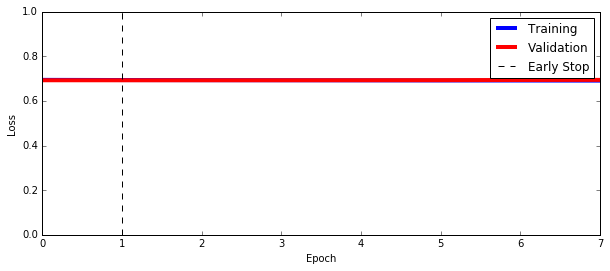

In [39]:
SequenceDNN_learning_curve(one_filter_dragonn)

Plotting simulation motifs...


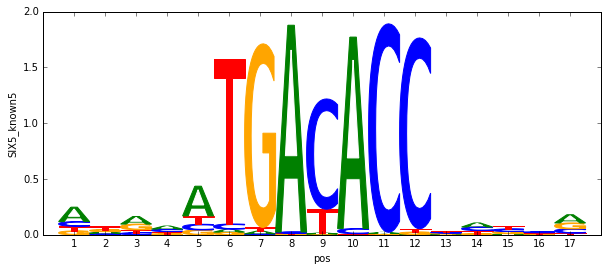

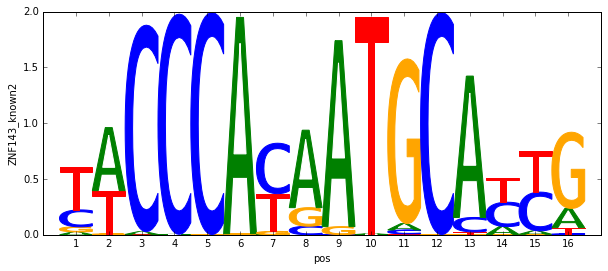

Visualizing convolutional sequence filters in SequenceDNN...


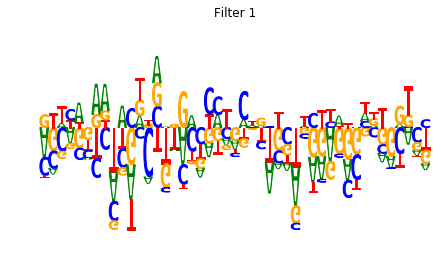

In [42]:
interpret_SequenceDNN_filters(one_filter_dragonn, simulation_data)

# A multi-filter DragoNN model 

In [7]:
# parameters for the multi filter Convolutional Neural Network

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7036	Balanced Accuracy: 51.90%	 auROC: 0.532	 auPRC: 0.525
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.7181	Balanced Accuracy: 48.71%	 auROC: 0.493	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.4%	 Num Positives: 1624	 Num Negatives: 1576 *
Epoch 2:
Train Loss: 0.6901	Balanced Accuracy: 54.07%	 auROC: 0.562	 auPRC: 0.552
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.7142	Balanced Accuracy: 48.32%	 auROC: 0.490	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.3%	 Num Positives: 1624	 Num Negatives: 1576 *
Epoch 3:
Train Loss: 0.6810	Balanced Accuracy: 55.84%	 auROC: 0.589	 auPRC: 0.578
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.7132	Balanced Accuracy: 48.67%	 auROC: 0.491	 auPRC: 0.506
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.3%	 Num Positives: 1624	

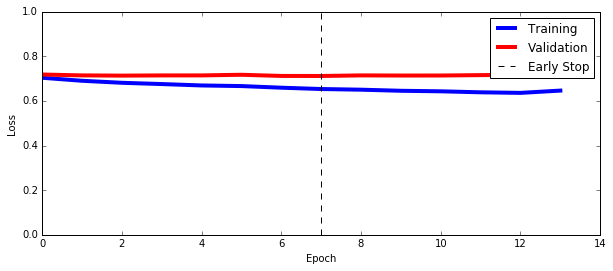

In [43]:
multi_filter_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [15], ## notice the change from 1 filter to 15 filters
    'conv_width': [45],
    'pool_width': 45,
    'dropout': 0.1}
multi_filter_dragonn = get_SequenceDNN(multi_filter_dragonn_parameters)
train_SequenceDNN(multi_filter_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_filter_dragonn)

Plotting simulation motifs...


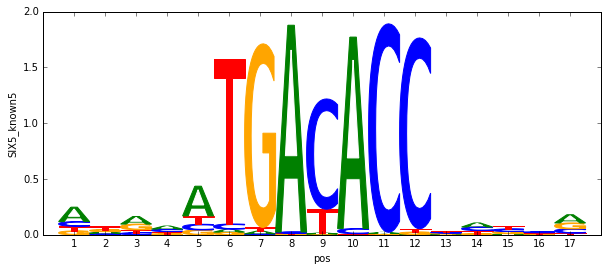

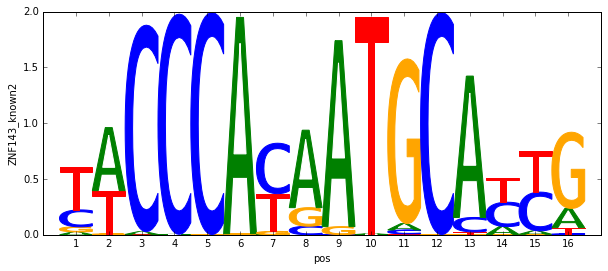

Visualizing convolutional sequence filters in SequenceDNN...


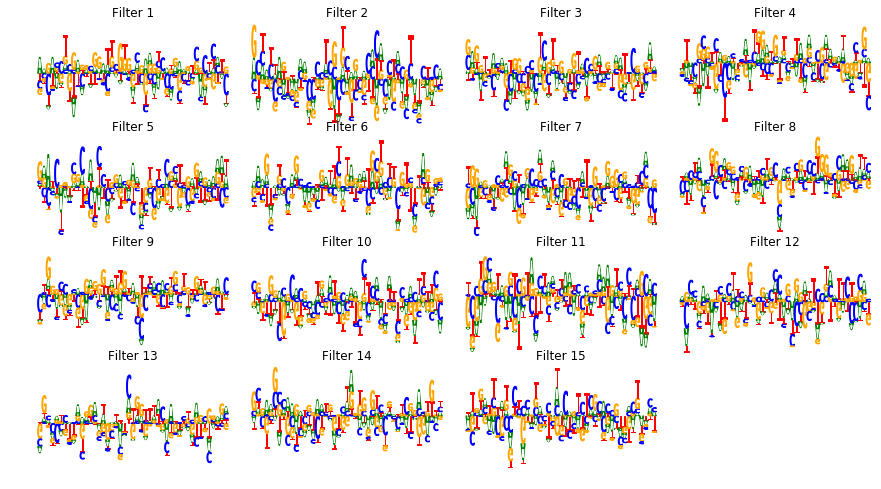

In [45]:
interpret_SequenceDNN_filters(multi_filter_dragonn, simulation_data)

# A multi-layer DragoNN model

In [8]:
# parameters for the multi layer - multi filter Convolutional Neural Network

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6928	Balanced Accuracy: 51.43%	 auROC: 0.522	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.2%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6950	Balanced Accuracy: 50.11%	 auROC: 0.498	 auPRC: 0.515
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1624	 Num Negatives: 1576 *
Epoch 2:
Train Loss: 0.6916	Balanced Accuracy: 52.23%	 auROC: 0.535	 auPRC: 0.522
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6952	Balanced Accuracy: 49.54%	 auROC: 0.499	 auPRC: 0.504
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1624	 Num Negatives: 1576
Epoch 3:
Train Loss: 0.6888	Balanced Accuracy: 54.25%	 auROC: 0.564	 auPRC: 0.552
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6368	 Num Negatives: 6432
Valid Loss: 0.6941	Balanced Accuracy: 49.76%	 auROC: 0.506	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1624	 N

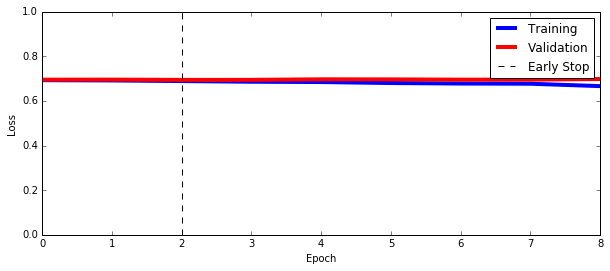

In [47]:
multi_layer_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [15, 15, 15], ## notice the change to multiple filter values, one for each layer
    'conv_width': [25, 25, 25], ## convolutional filter width has been modified to 25 from 45
    'pool_width': 45,
    'dropout': 0.1}
multi_layer_dragonn = get_SequenceDNN(multi_layer_dragonn_parameters)
train_SequenceDNN(multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_layer_dragonn)

Plotting simulation motifs...


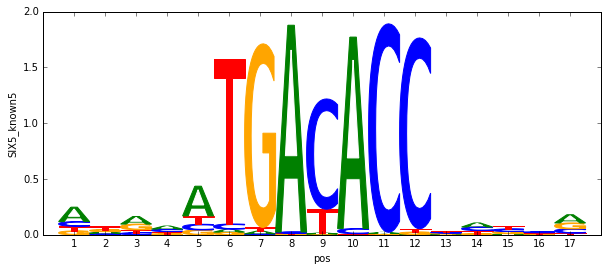

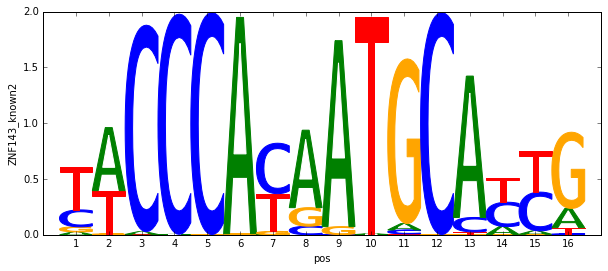

Visualizing convolutional sequence filters in SequenceDNN...


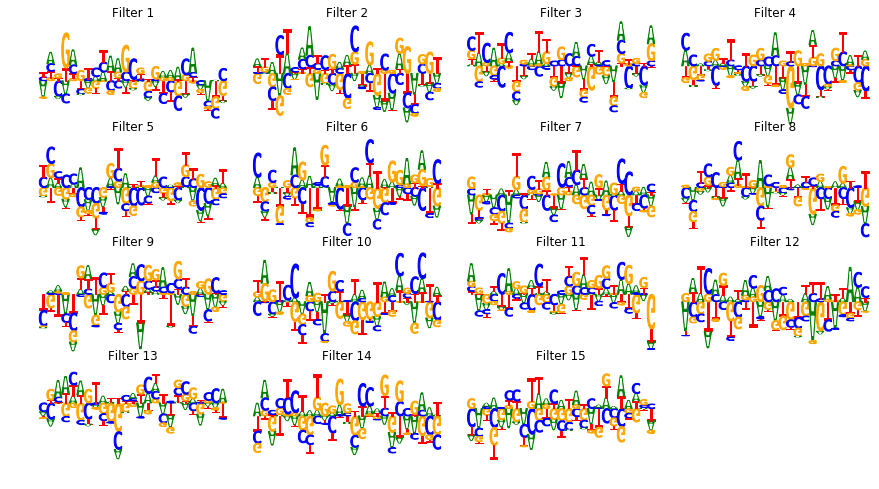

In [48]:
interpret_SequenceDNN_filters(multi_layer_dragonn, simulation_data)

# CNN based binary classification

In [52]:
heterodimer_grammar_simulation_parameters = {
    "seq_length": 500,
    "GC_fraction": 0.4,
    "num_pos": 10000,
    "num_neg": 10000,
    "motif1": "SPI1_known4",
    "motif2": "IRF_known20",
    "min_spacing": 2,
    "max_spacing": 5}

simulation_data = get_simulation_data("simulate_heterodimer_grammar", heterodimer_grammar_simulation_parameters)

In [53]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int, optional
    length of input sequence.
keras_model : instance of keras.models.Sequential, optional
    seq_length or keras_model must be specified.
num_tasks : int, optional
    number of tasks. Default: 1.
num_filters : list[int] | tuple[int]
    number of convolutional filters in each layer. Default: (15,).
conv_width : list[int] | tuple[int]
    width of each layer's convolutional filters. Default: (15,).
pool_width : int
    width of max pooling after the last layer. Default: 35.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
verbose: int
    Verbosity level during training. Valida values: 0, 1, 2.

Returns
-------
Compiled DNN model.

Available methods:

deeplift
get_sequence_filters
in_silico_mutagenesis
plot_architecture
plot_deeplift
plot_in_silico_mutagenesis
predict
save
score
test
train


In [57]:
deep_cnn_parameters = {
    'seq_length': 500,
    'num_filters': [15,15,15],
    'conv_width': [15,15,15],
    'pool_width': 35}

In [58]:
deep_cnn_model = get_SequenceDNN(deep_cnn_parameters)

In [59]:
train_SequenceDNN(deep_cnn_model, simulation_data)

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6910	Balanced Accuracy: 53.12%	 auROC: 0.546	 auPRC: 0.537
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6382	 Num Negatives: 6418
Valid Loss: 0.6978	Balanced Accuracy: 50.40%	 auROC: 0.502	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.3%	 Num Positives: 1604	 Num Negatives: 1596 *
Epoch 2:
Train Loss: 0.6833	Balanced Accuracy: 56.03%	 auROC: 0.594	 auPRC: 0.581
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.2%	 Num Positives: 6382	 Num Negatives: 6418
Valid Loss: 0.6968	Balanced Accuracy: 49.87%	 auROC: 0.506	 auPRC: 0.508
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 1604	 Num Negatives: 1596 *
Epoch 3:
Train Loss: 0.6744	Balanced Accuracy: 59.88%	 auROC: 0.634	 auPRC: 0.622
	Recall at 5%|10%|20% FDR: 0.1%|0.3%|1.7%	 Num Positives: 6382	 Num Negatives: 6418
Valid Loss: 0.6969	Balanced Accuracy: 50.37%	 auROC: 0.506	 auPRC: 0.507
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1604	

In [60]:
test_SequenceDNN(deep_cnn_model, simulation_data)

Test performance:
Loss: 0.7166	Balanced Accuracy: 49.87%	 auROC: 0.496	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2014	 Num Negatives: 1986


Plotting simulation motifs...


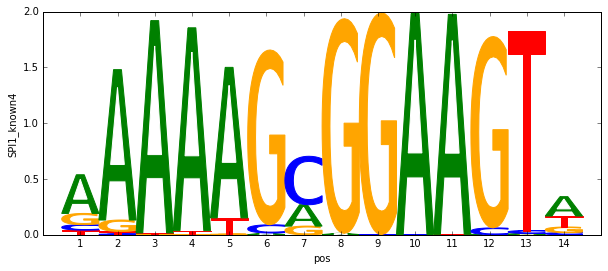

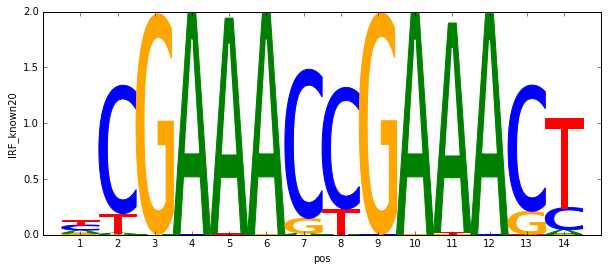

Visualizing convolutional sequence filters in SequenceDNN...


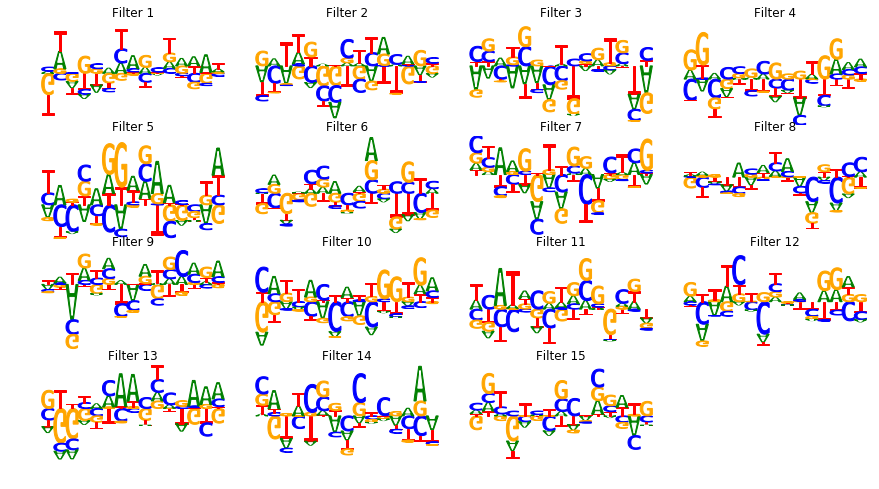

In [62]:
interpret_SequenceDNN_filters(deep_cnn_model, simulation_data)